# Failing Loudly - dSprites

**Description**: In this notebook, we will apply various type of shifts to the dSprite dataset.

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import scipy.io
from math import ceil
from copy import deepcopy

# Change figure aesthetics
%matplotlib inline
# sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 1.5})

## Utilities

Contains helper functions.

In [3]:
def get_latent_sizes():
    """
    Get the size of each concept (see details above).
    """
    
    return np.array([1, 3, 6, 40, 32, 32])

def get_latent_bases():
    """
    Given vector (x, y, z) where each dimension is in base (a, b, c).
    The following function will convert each of (x, y, z) dimensions to decimal.
    """
    
    latent_sizes = get_latent_sizes()
    latent_bases = np.concatenate((latent_sizes[::-1].cumprod()[::-1][1:],
                                np.array([1,])))
    
    return latent_bases

In [4]:
def sample_latent(size=1):
    """
    Used to randomly sample latent of size 'size'
    """
    
    latents_sizes = get_latent_sizes()
    samples = np.zeros((size, len(latents_sizes)))
    for lat_i, lat_size in enumerate(latents_sizes):
        samples[:, lat_i] = np.random.randint(lat_size, size=size)

    return samples

In [5]:
def latent_to_index(latents):
    """
    Convert from given latent to index position of it in the dataset
    """
    
    latents_bases = get_latent_bases()
    return np.dot(latents, latents_bases).astype(int)

In [6]:
def show_images_grid(imgs_, num_images=25):
    """
    Used to visualise dSprite image in a grid
    """
    
    ncols = int(np.ceil(num_images**0.5))
    nrows = int(np.ceil(num_images / ncols))
    _, axes = plt.subplots(ncols, nrows, figsize=(nrows * 3, ncols * 3))
    axes = axes.flatten()
    
    # Draw images on the given grid
    for ax_i, ax in enumerate(axes):
        if ax_i < num_images:
            ax.imshow(imgs_[ax_i], cmap='Greys_r',  interpolation='nearest')
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            ax.axis('off')

## Exploring dSprites

In this section, we will load and visualise the dSprite datasets.

### Load dataset

In [8]:
# Load dataset (the zip file)
dataset_zip = np.load('dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz')

# Extract relevant datas from the zip file
imgs = dataset_zip["imgs"] # contains image data (737280 x 64 x 64)
latents_values = dataset_zip['latents_values'] # values of latent factors (or in this case concepts)
latents_classes = dataset_zip['latents_classes'] # classification targets (integer index of latents_values)

### Splitting Training/ Testing Set

In [14]:
# RAM cannot handle everything
ndata = 100000
imgs = imgs[:ndata]
latents_classes = latents_classes[:ndata]

In [15]:
concept_names = ['color', 'shape', 'scale', 'rotation', 'x_pos', 'y_pos']
class_index = 1 # shape

X = imgs # image
# X = np.expand_dims(X, axis=-1)
# X = X.astype(('float32'))
y = latents_classes[:, class_index] # shape for task 1
c = latents_classes # concepts

# Split X (image), y (shape for task 1), concepts to train test sets
# X_train, X_test, y_train, y_test, c_train, c_test = train_test_split(X, y, c, train_size=0.85)
# print('Training samples:', X_train.shape[0])
# print('Testing samples:', X_test.shape[0])

In [62]:
# Validation set
# X_train, X_valid = X_train[:70000], X_train[70000:]
# y_train, y_valid = y_train[:70000], y_train[70000:]
# c_train, c_valid = c_train[:70000], c_train[70000:]

### Apply Dataset Shifts

In [43]:
def gaussian_noise_subset(x, noise_amt, normalization=1.0, delta_total=1.0, clip=True):
    """
    Apply gaussian noise to subset of data.
    """
    
    # Indices of data that will be shifted
    indices = np.random.choice(x.shape[0], 15000, replace=False)
    x_mod = x[indices, :]
    
#     print(x_mod.shape)
    noise = np.random.normal(0, noise_amt / normalization, (x_mod.shape[0], x_mod.shape[1], x_mod.shape[2]))
#     print(noise.shape)
    if clip:
        x_mod = np.clip(x_mod + noise, 0., 1.)
    else:
        x_mod = x_mod + noise
    
    # new data
    x[indices, :] = x_mod
    return x, indices

In [44]:
def apply_shift(X_te_orig, y_te_orig, shift, orig_dims, datset):
    """
    Used to apply dataset shifts to X and y.
    """
    
    X_te_1 = None
    y_te_1 = None

    if shift == 'rand':
        print('Randomized')
        X_te_1 = X_te_orig.copy()
        y_te_1 = y_te_orig.copy()
    elif shift == 'large_gn_shift_1.0':
        print('Large GN shift')
        normalization = 255.0
        X_te_1, indices = gaussian_noise_subset(X_te_orig, 100.0, normalization=normalization, delta_total=1.0)
        y_te_1 = y_te_orig.copy()
    elif shift == 'medium_gn_shift_1.0':
        print('Medium GN Shift')
        normalization = 255.0
        X_te_1, indices = gaussian_noise_subset(X_te_orig, 10.0, normalization=normalization, delta_total=1.0)
        y_te_1 = y_te_orig.copy()
    elif shift == 'small_gn_shift_1.0':
        print('Small GN Shift')
        normalization = 255.0
        X_te_1, indices = gaussian_noise_subset(X_te_orig, 1.0, normalization=normalization, delta_total=1.0)
        y_te_1 = y_te_orig.copy()

    return (X_te_1, y_te_1, indices)

In [45]:
X_large_gaussian = deepcopy(X)
y_large_gaussian = deepcopy(y)

# Apply large gaussian shift
X_large_gaussian, y_large_gaussian, indices = apply_shift(X_large_gaussian, y_large_gaussian, "large_gn_shift_1.0", None, None)


Large GN shift


**Before shift**

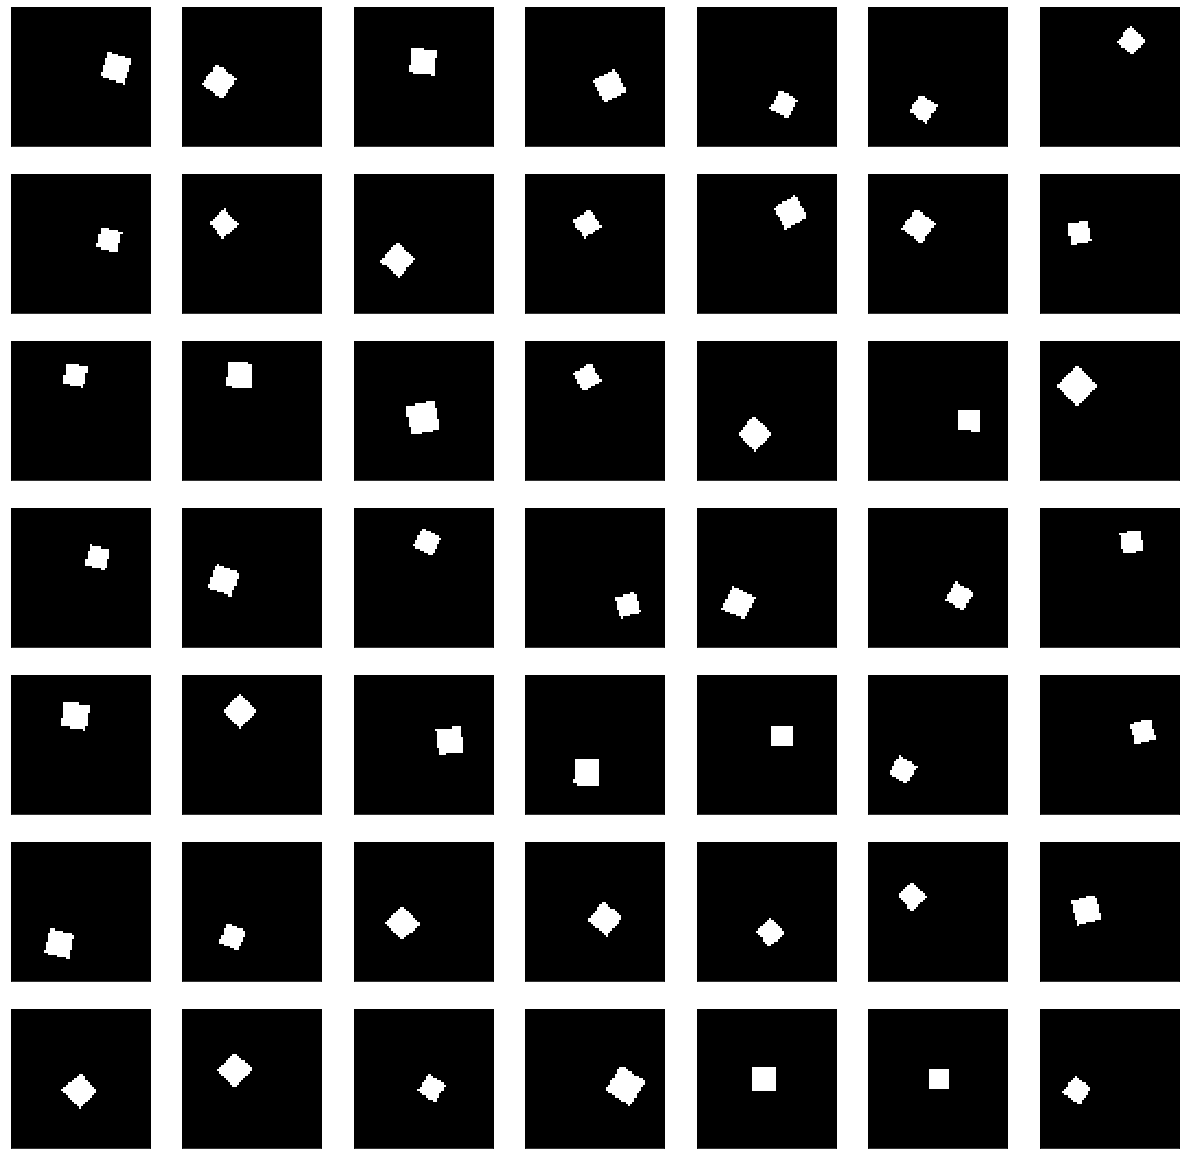

In [53]:
imgs_sampled = X[indices]

# Show images
show_images_grid(imgs_sampled, num_images=49)

**After shift**

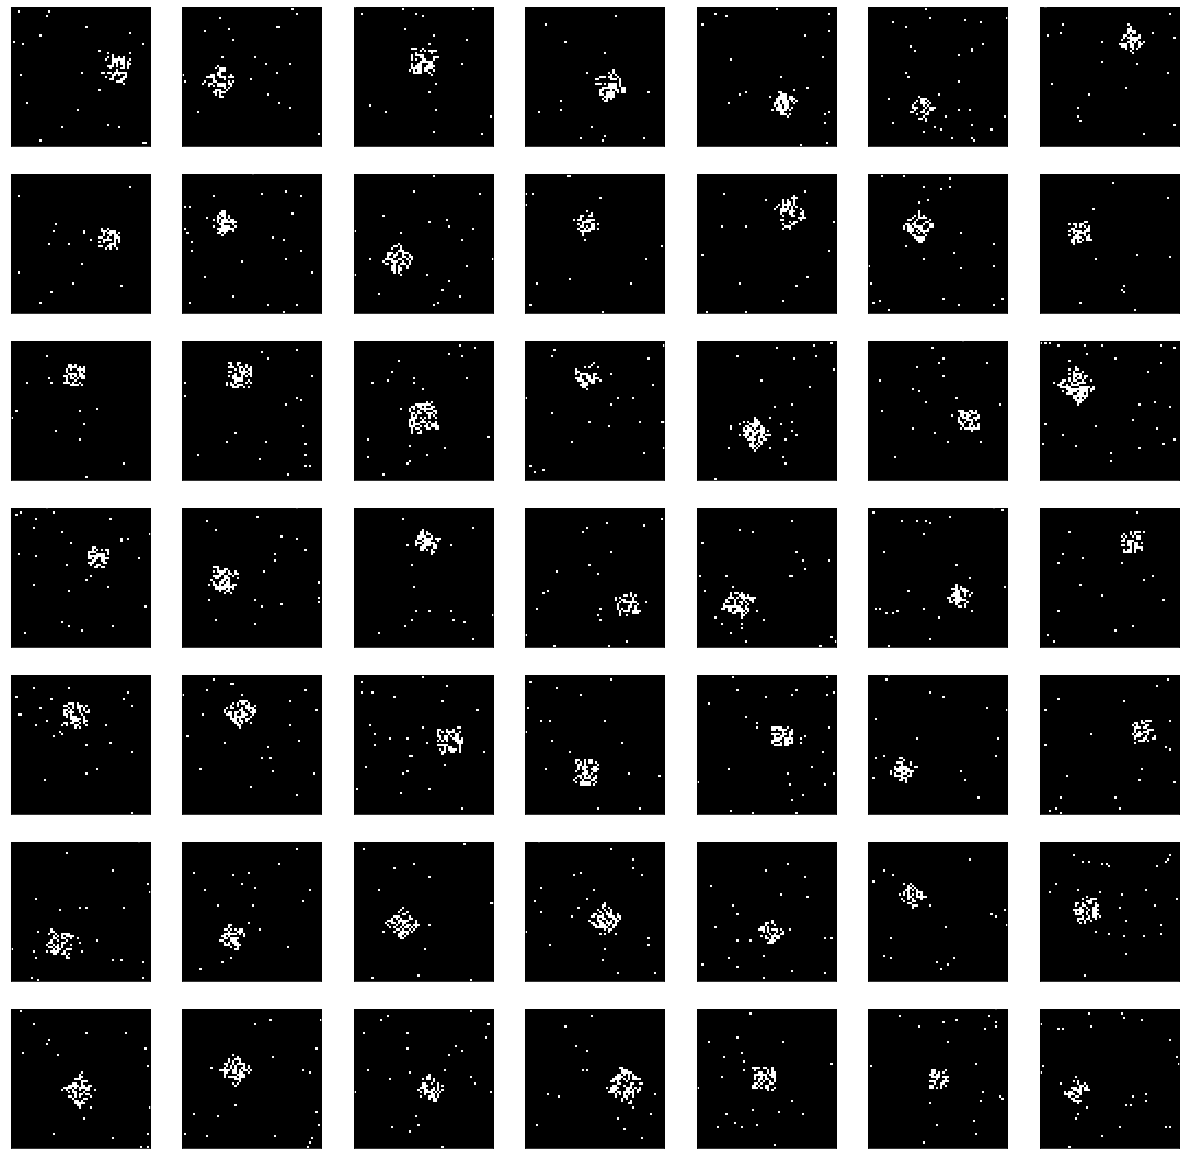

In [52]:
imgs_sampled = X_large_gaussian[indices]

# Show images
show_images_grid(imgs_sampled, num_images=49)